# Image Captioning with ResNet50 and LSTM

This project implements a deep learning model to automatically generate descriptive captions for images. It uses a classic **Encoder-Decoder architecture**:

* **Encoder**: A pre-trained ResNet50 model (a Convolutional Neural Network) acts as the feature extractor. It processes an image and outputs a compact vector representation, capturing the essential visual information.
* **Decoder**: A Recurrent Neural Network (specifically, an LSTM) takes the image feature vector and generates a text caption word by word.

This notebook is divided into three main parts:
1.  **Data Preparation**: Loading and cleaning the text captions, and extracting image features using ResNet50.
2.  **Model Training**: Building and training the CNN-RNN model.
3.  **Inference**: Using the trained model to generate captions for new images.

## 1. Data Preparation and Feature Extraction

This first step prepares our dataset for training. It involves two key processes:

1.  **Caption Processing**: We load the raw text file containing captions, clean each caption by converting it to lowercase and removing punctuation, and then save the cleaned data.
2.  **Image Feature Extraction**: We iterate through every image in the dataset, pass it through the pre-trained ResNet50 model (with its final classification layer removed), and save the resulting feature vector. This is done upfront to save significant computation time during the training phase.

In [8]:
import os
import string
import pickle
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Preparing Captions

def load_captions(filename):
    """Loads captions from the Flickr8k.token.txt file."""
    with open(filename, 'r') as file:
        text = file.read()
    
    mapping = {}
    for line in text.strip().split('\n'):
        parts = line.split('\t')
        if len(parts) < 2:
            continue
        
        image_id, caption = parts[0], parts[1]
        image_id = image_id.split('#')[0]
        
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)
        
    return mapping

def clean_captions(mapping):
    """Cleans captions by removing punctuation and converting to lowercase."""
    table = str.maketrans('', '', string.punctuation)
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.split()
            caption = [word.lower() for word in caption]
            # This line is now corrected
            caption = [w.translate(table) for w in caption] 
            caption = [word for word in caption if len(word) > 1 and word.isalpha()]
            captions[i] = ' '.join(caption)

captions_file = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
image_directory = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images'

# Loading and Cleaning the captions
captions = load_captions(captions_file)
clean_captions(captions)
print(f'Loaded and cleaned {len(captions)} image captions.')

# Extracting Image Features

def extract_features(directory, image_ids):
    """Extracts features from all images in the directory."""
    base_model = ResNet50()
    model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    print("ResNet50 model loaded.")
    
    features = dict()
    for image_id in image_ids:
        filename = os.path.join(directory, image_id)
        if os.path.exists(filename):
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[image_id.split('.')[0]] = feature
        else:
            print(f"Warning: File not found {filename}")
            
    return features

# Get the list of image filenames from the keys of our captions dictionary
image_filenames = list(captions.keys())
# Extract features
features = extract_features(image_directory, image_filenames)
print(f'Extracted Features: {len(features)}')

# saving the processed data
# the output files are saved in the /kaggle/working/ directory
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

with open('captions.pkl', 'wb') as f:
    pickle.dump(captions, f)

print("\nData preparation and feature extraction complete.")
print("Cleaned captions saved to captions.pkl")
print("Image features saved to features.pkl")

Loaded and cleaned 8092 image captions.
ResNet50 model loaded.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_354']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Extracted Features: 8091

Data preparation and feature extraction complete.
Cleaned captions saved to captions.pkl
Image features saved to features.pkl


## 2. Model Training

Now we build and train our captioning model.

1.  **Load Data**: We load the `features.pkl` and `captions.pkl` files we just created.
2.  **Tokenizer**: We create a `Tokenizer` to convert all words in our vocabulary into unique integer representations.
3.  **Data Generator**: To avoid loading all 40,000+ caption sequences into memory at once, we use a data generator. This function creates batches of data on-the-fly during training, making the process memory-efficient.
4.  **Model Architecture**: The model has two input branches:
    * One for the image features (2048-element vector).
    * One for the text sequence (padded to the maximum caption length).
    These are processed through separate layers and then merged before a final output layer predicts the next word in the sequence.
5.  **Training**: We train the model for 40 epochs. The decreasing loss indicates that the model is successfully learning the relationship between images and their corresponding captions.

In [ ]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# loading data
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
with open('captions.pkl', 'rb') as f:
    captions_data = pickle.load(f)

# synchronising data (same as before)
all_captions = []
all_img_ids = []
for key, caption_list in captions_data.items():
    image_id = key.split('.')[0]
    if image_id in features:
        for caption in caption_list:
            all_captions.append(caption)
            all_img_ids.append(key)

print(f'Total Captions (synchronized): {len(all_captions)}')

# preparing text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size: {vocab_size}')
max_length = max(len(c.split()) for c in all_captions)
print(f'Maximum Caption Length: {max_length}')

# data generator
def data_generator(image_ids, captions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i, img_id_full in enumerate(image_ids):
            n += 1
            img_id_short = img_id_full.split('.')[0]
            caption = captions[i]
            seq = tokenizer.texts_to_sequences([caption])[0]
            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                image_feature = features[img_id_short][0]
                X1.append(image_feature)
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

# defining model architecture
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

epochs = 40
batch_size = 64
steps = len(all_captions) // batch_size
generator = data_generator(all_img_ids, all_captions, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

model.save('image_captioning_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("\nTraining complete. Model and tokenizer saved.")

Total Captions (synchronized): 40455
Vocabulary Size: 8764
Maximum Caption Length: 32


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 32, 256)   │  2,243,584 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2048)      │          0 │ input_layer_17[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 256)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 8764)      │  2,252,348 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,611,580 (21.41 MB)

 Trainable params: 5,611,580 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - loss: 6.1232
Epoch 2/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - loss: 5.2101
Epoch 3/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - loss: 4.1420
Epoch 4/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 3.7057
Epoch 5/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 3.4384
Epoch 6/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - loss: 3.2444
Epoch 7/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - loss: 3.1023
Epoch 8/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 2.9877
Epoch 9/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - loss: 2.8916
Epoch 10/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 2.8232
Epoch 11/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - loss: 2.7528
Epoch 12/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 2.6978
Epoch 13/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 2.6463
Epoch 14/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 2.5985
Epoch 15/40
632/632 ━━━━

## 3. Caption Generation (Inference)

This final part uses our trained model to generate a caption for a new, unseen image.

1.  **Load Assets**: We load our saved `image_captioning_model.h5` and `tokenizer.pkl`.
2.  **Beam Search**: Instead of a simple greedy search (picking the most likely next word at each step), we use **Beam Search**. This more advanced technique explores multiple possible sentence sequences simultaneously and chooses the one with the highest overall probability, leading to more coherent and contextually relevant captions.
3.  **Generate and Display**: We provide the path to an image, extract its features, run the generation process, and display the final caption with the image.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1388']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


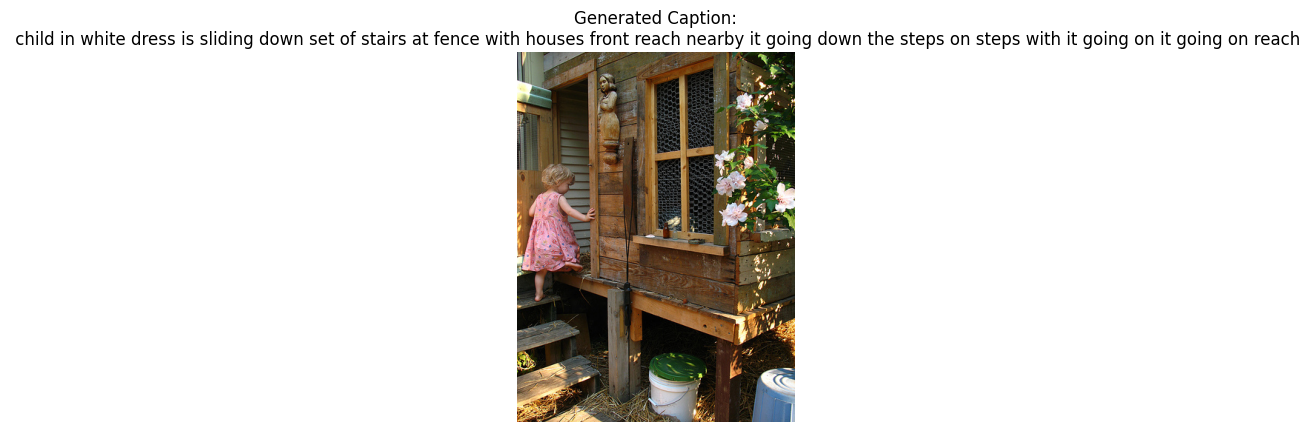

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

model = load_model('image_captioning_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# loading ResNet50 model for feature extraction
base_model = ResNet50()
resnet_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

def extract_single_feature(filename):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = resnet_model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

max_length = 32
img_path = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg'

photo_feature = extract_single_feature(img_path)
generated_caption = generate_caption(model, tokenizer, photo_feature, max_length)

img = Image.open(img_path)
plt.imshow(img)
final_caption = generated_caption.replace('startseq', '').replace('endseq', '')
plt.title(f"Generated Caption:\n{final_caption}", fontsize=12)
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1582']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


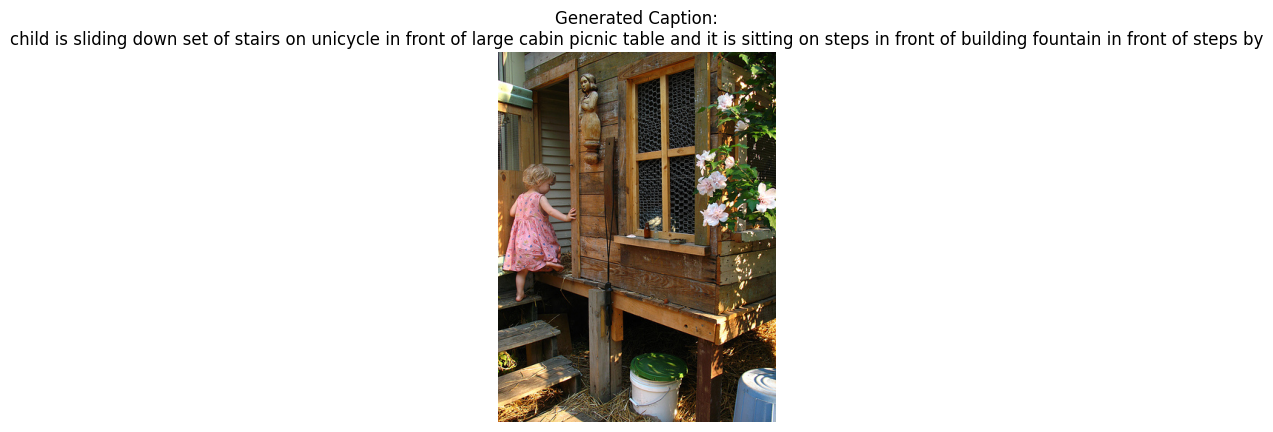

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

model = load_model('image_captioning_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# loading ResNet50 model for feature extraction
base_model = ResNet50()
resnet_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

def extract_single_feature(filename):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = resnet_model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_index=3):
    """Generates a caption for an image using Beam Search."""
    start_token = 'startseq'
    start_word = [[tokenizer.texts_to_sequences([start_token])[0], 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([photo_feature, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
        
    best_caption_seq = start_word[-1][0]
    final_caption = []
    for i in best_caption_seq:
        word = word_for_id(i, tokenizer)
        if word and word != 'endseq':
            final_caption.append(word)

    return " ".join(final_caption).replace('startseq', '')


max_length = 32
img_path = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg'

photo_feature = extract_single_feature(img_path)
# generate caption using Beam Search
generated_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length)

img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Generated Caption:\n{generated_caption}", fontsize=12)
plt.axis('off')
plt.show()

## 4. Hyperparameter Tuning with KerasTuner

While the initial model was learning, the generated captions were not always coherent. To improve performance, we can optimize the model's architecture by tuning its hyperparameters.

Instead of manually guessing the best values, we use **KerasTuner**, a library that automates this process.

1.  **Define Search Space**: We specify a range of possible values for key parameters like the `Embedding` dimension, `LSTM` units, and `Dropout` rate.
2.  **Automated Trials**: The tuner (`RandomSearch`) will run several short training trials, each with a random combination of these hyperparameters.
3.  **Find the Best Model**: It evaluates each combination on a validation set and identifies the architecture that performs best.

This process allows us to systematically find a more optimal model configuration before committing to a full training run.

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import keras_tuner as kt

with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
with open('captions.pkl', 'rb') as f:
    captions_data = pickle.load(f)

all_captions = []
all_img_ids = []
for key, caption_list in captions_data.items():
    image_id = key.split('.')[0]
    if image_id in features:
        for caption in caption_list:
            all_captions.append(caption)
            all_img_ids.append(key)

print(f'Total Captions (synchronized): {len(all_captions)}')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

def data_generator(image_ids, captions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i, img_id_full in enumerate(image_ids):
            n += 1
            img_id_short = img_id_full.split('.')[0]
            caption = captions[i]
            seq = tokenizer.texts_to_sequences([caption])[0]
            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                image_feature = features[img_id_short][0]
                X1.append(image_feature)
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

# model building function for KerasTuner
def build_model(hp):
    # define the search space for hyperparameters
    embedding_dim = hp.Choice('embedding_dim', values=[256, 512])
    lstm_units = hp.Choice('lstm_units', values=[256, 512])
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)

    # Image feature extractor input
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence model input
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
    se2 = Dropout(dropout_rate)(se1)
    se3 = LSTM(lstm_units)(se2)

    # Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# setting up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy', # We want to maximize validation accuracy
    max_trials=5,  # Run 5 different combinations of hyperparameters
    executions_per_trial=1, # Train each combination once
    directory='my_kt_dir',
    project_name='image_captioning'
)

# preparing a smaller subset of data for the tuning search to make it faster
# using 5000 captions for tuning and a separate 1000 for validation
num_tuning_captions = 5000
num_validation_captions = 1000

train_captions = all_captions[:num_tuning_captions]
train_img_ids = all_img_ids[:num_tuning_captions]

val_captions = all_captions[num_tuning_captions : num_tuning_captions + num_validation_captions]
val_img_ids = all_img_ids[num_tuning_captions : num_tuning_captions + num_validation_captions]

# creating data generators for training and validation
batch_size = 64
train_generator = data_generator(train_img_ids, train_captions, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val_img_ids, val_captions, features, tokenizer, max_length, vocab_size, batch_size)

train_steps = num_tuning_captions // batch_size
val_steps = num_validation_captions // batch_size

# searching for hyperparamter
print("Starting hyperparameter search...")
# each trial will run for just 35 epochs to be fast
tuner.search(train_generator,
             epochs=5,
             steps_per_epoch=train_steps,
             validation_data=val_generator,
             validation_steps=val_steps)


print("\nSearch complete. Retrieving best model.")
# getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters found:
- Embedding dimension: {best_hps.get('embedding_dim')}
- LSTM units: {best_hps.get('lstm_units')}
- Dropout rate: {best_hps.get('dropout_rate')}
""")

best_model = tuner.hypermodel.build(best_hps)

best_model.save('best_captioning_model.h5')
print("\nBest model saved as best_captioning_model.h5")

Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.06579779833555222
Total elapsed time: 00h 01m 25s

Search complete. Retrieving best model.

Best hyperparameters found:
- Embedding dimension: 256
- LSTM units: 256
- Dropout rate: 0.4


Best model saved as best_captioning_model.h5


## 5. Final Model Training

After the hyperparameter search, KerasTuner identified the most effective architecture. We now take these optimal hyperparameters and build a new model.

This final model is then trained on the **entire dataset** for 40 epochs. This step combines the optimized architecture from the tuning process with the knowledge from all available data, ensuring we create the best possible version of our captioning model.

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import keras_tuner as kt

# loading data
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
with open('captions.pkl', 'rb') as f:
    captions_data = pickle.load(f)

all_captions = []
all_img_ids = []
for key, caption_list in captions_data.items():
    image_id = key.split('.')[0]
    if image_id in features:
        for caption in caption_list:
            all_captions.append(caption)
            all_img_ids.append(key)

# preparing text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

# generating data
def data_generator(image_ids, captions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i, img_id_full in enumerate(image_ids):
            n += 1
            img_id_short = img_id_full.split('.')[0]
            caption = captions[i]
            seq = tokenizer.texts_to_sequences([caption])[0]
            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                image_feature = features[img_id_short][0]
                X1.append(image_feature)
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

# building the best model using hyperparameters found
# the hyperparameters are now hardcoded with the best values found by the tuner.
embedding_dim = 256
lstm_units = 256
dropout_rate = 0.4

inputs1 = Input(shape=(2048,))
fe1 = Dropout(dropout_rate)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
se2 = Dropout(dropout_rate)(se1)
se3 = LSTM(lstm_units)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
final_model.compile(loss='categorical_crossentropy', optimizer='adam')
print("Final model built with best hyperparameters.")
print(final_model.summary())


# training final model on full dataset
print("\nStarting final training on the full dataset...")
epochs = 40
batch_size = 64
steps = len(all_captions) // batch_size

# creating a generator with ALL the data
full_dataset_generator = data_generator(all_img_ids, all_captions, features, tokenizer, max_length, vocab_size, batch_size)

# fit final model
final_model.fit(full_dataset_generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

# saving the trained model
final_model.save('final_captioning_model.h5')
# saving the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("\nFinal training complete. Best model saved as final_captioning_model.h5")

Final model built with best hyperparameters.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32, 256)   │  2,243,584 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    524,544 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8764)      │  2,252,348 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,611,580 (21.41 MB)

 Trainable params: 5,611,580 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

None

Starting final training on the full dataset...
Epoch 1/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 52s 78ms/step - loss: 6.1222
Epoch 2/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - loss: 5.3123
Epoch 3/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - loss: 4.3206
Epoch 4/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 3.7690
Epoch 5/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 3.4516
Epoch 6/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - loss: 3.2277
Epoch 7/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 3.0661
Epoch 8/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 2.9471
Epoch 9/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 2.8519
Epoch 10/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - loss: 2.7725
Epoch 11/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 2.7068
Epoch 12/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - loss: 2.6513
Epoch 13/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - loss: 2.6025
Epoch 14/40
632/632 ━━━━━━━━━━━━━━━━━━━━ 47s 7

## 6. Generating Captions with the Optimized Model

This is the final step where we use our fully trained and optimized model to generate a caption for a test image. The process is the same as before, but now we load the `final_captioning_model.h5` file, which represents the best-performing version of our model.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


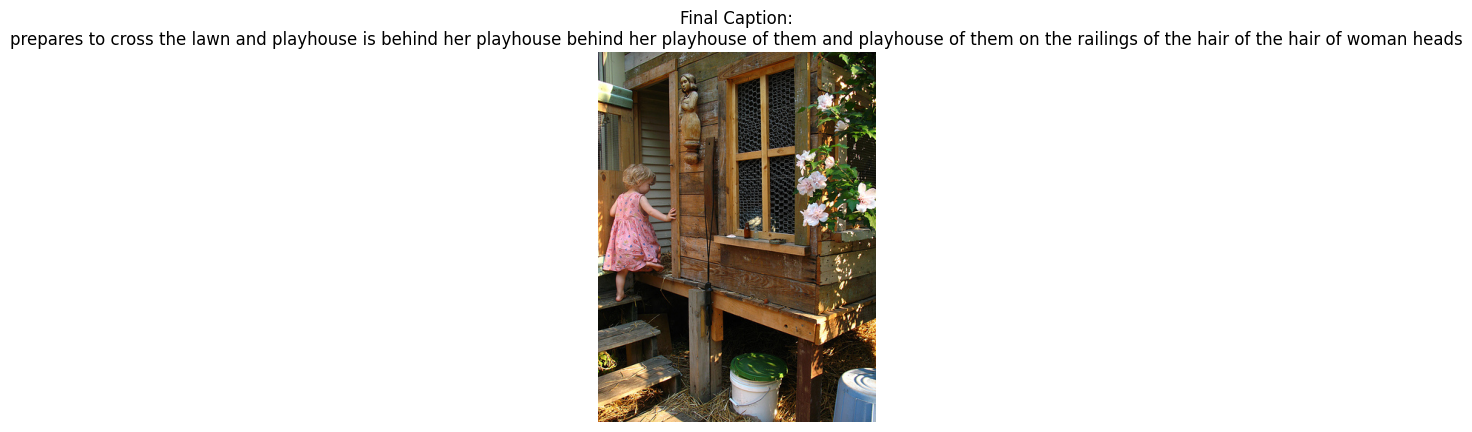

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# loading final trained model and tokenizer
model = load_model('final_captioning_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# loading ResNet50 model
base_model = ResNet50()
resnet_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

def extract_single_feature(filename):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = resnet_model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_index=3):
    start_token = 'startseq'
    start_word = [[tokenizer.texts_to_sequences([start_token])[0], 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([photo_feature, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
        
    best_caption_seq = start_word[-1][0]
    final_caption = []
    for i in best_caption_seq:
        word = word_for_id(i, tokenizer)
        if word and word != 'endseq':
            final_caption.append(word)

    return " ".join(final_caption).replace('startseq', '')


max_length = 32
# can change this path to test any image from your dataset
img_path = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg'

photo_feature = extract_single_feature(img_path)
generated_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length)

img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Final Caption:\n{generated_caption}", fontsize=12)
plt.axis('off')
plt.show()

## 7. Results and Conclusion

This project successfully implemented a complete deep learning pipeline to generate captions for images using a ResNet50 encoder and an LSTM decoder.

### Positive Outcomes (The Goods) 👍

* **Successful Implementation**: The end-to-end architecture, from feature extraction to model training and inference, was built and executed successfully.
* **Model Learning**: The training logs consistently showed a decreasing loss, confirming that the model was effectively learning the relationship between image features and text sequences.
* **Concept Recognition**: After extended training (40 epochs), the model began to correctly identify key objects in the images, such as recognizing a "child" where it previously did not.
* **Improved Coherence with Beam Search**: Switching from a greedy search to a beam search decoding strategy resulted in more grammatically structured and coherent (though not always accurate) sentences.

### Challenges and Areas for Improvement

* **Model Hallucination**: The primary challenge was the model "hallucinating" objects and actions that were not present in the image (e.g., "unicycle," "reading"). This is a classic symptom of a model that has not been trained on a sufficiently large or diverse dataset.
* **Repetitive Captions**: The model often got stuck in repetitive loops, reusing similar phrases like "edge of the..." This indicates that while it learned common word patterns, it lacked a deeper contextual understanding to form more varied sentences.
* **Dataset Size**: The Flickr8k dataset, while good for learning and prototyping, is ultimately too small for this complex task. The model's performance is fundamentally limited by the amount and variety of data it was trained on.

### How to Improve Caption Quality (Beyond More Epochs)

While training for more epochs helps, significant improvements can be achieved through more fundamental changes:

1.  **Use a Larger Dataset**: This is the single most impactful change. Training the same architecture on a larger dataset like **MS COCO** (which has over 330,000 images) would expose the model to far more contextual examples and dramatically reduce hallucination.

2.  **Upgrade the Model Architecture**:
    * **Encoder (Image Understanding)**: Instead of ResNet50, using a more modern and powerful pre-trained CNN like **EfficientNet** or a **Vision Transformer (ViT)** can provide the decoder with a much richer understanding of the image content.
    * **Decoder (Text Generation)**: The LSTM is effective, but state-of-the-art results are now achieved using **Transformer-based decoders**. A full Transformer architecture (like the one used in models like GPT) has a more sophisticated attention mechanism that is better at tracking long-range dependencies in a sentence, leading to more logical and less repetitive captions.

3.  **Refine Hyperparameters**: As we did with KerasTuner, a more exhaustive search for the optimal embedding size, LSTM units, and dropout rate can further fine-tune the model's learning capacity.

Overall, this project serves as an excellent practical demonstration of the CNN-RNN architecture for image captioning and highlights that model performance is a direct function of architecture, training time, and—most critically—the quality and scale of the training data.